In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

In [9]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


In [10]:
try:
    train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
    test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
    print("Loaded data from local Kaggle path.")
except FileNotFoundError:
    print("Local files not found. Loading from public URL.")
    train_df = pd.read_csv('https://raw.githubusercontent.com/chriskhanhtran/kaggle-house-price/master/Data/train.csv', index_col='Id')
    test_df = pd.read_csv('https://raw.githubusercontent.com/chriskhanhtran/kaggle-house-price/master/Data/test.csv', index_col='Id')


Local files not found. Loading from public URL.


In [38]:
print("\n--- Data Loading ---")
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)
print(train_df.head())


--- Data Loading ---
Training data shape: (1458, 80)
Testing data shape: (1459, 79)
    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corn

Text(0.5, 1.0, 'Distribution of Original SalePrice')

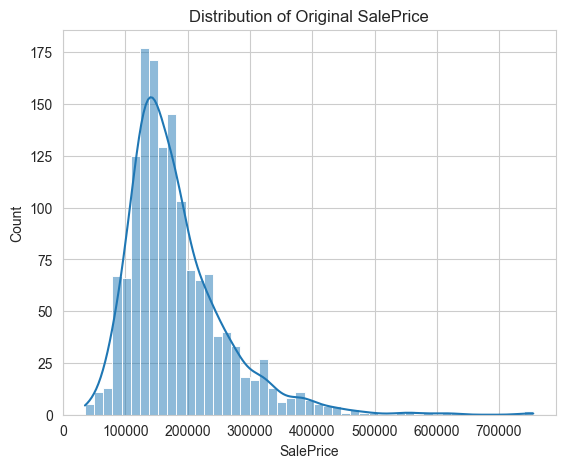

In [12]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of Original SalePrice')

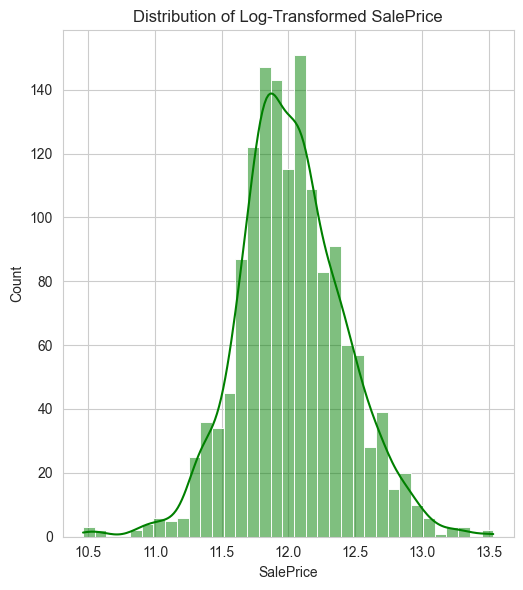

In [13]:
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_df['SalePrice']), kde=True, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.tight_layout()
plt.show()

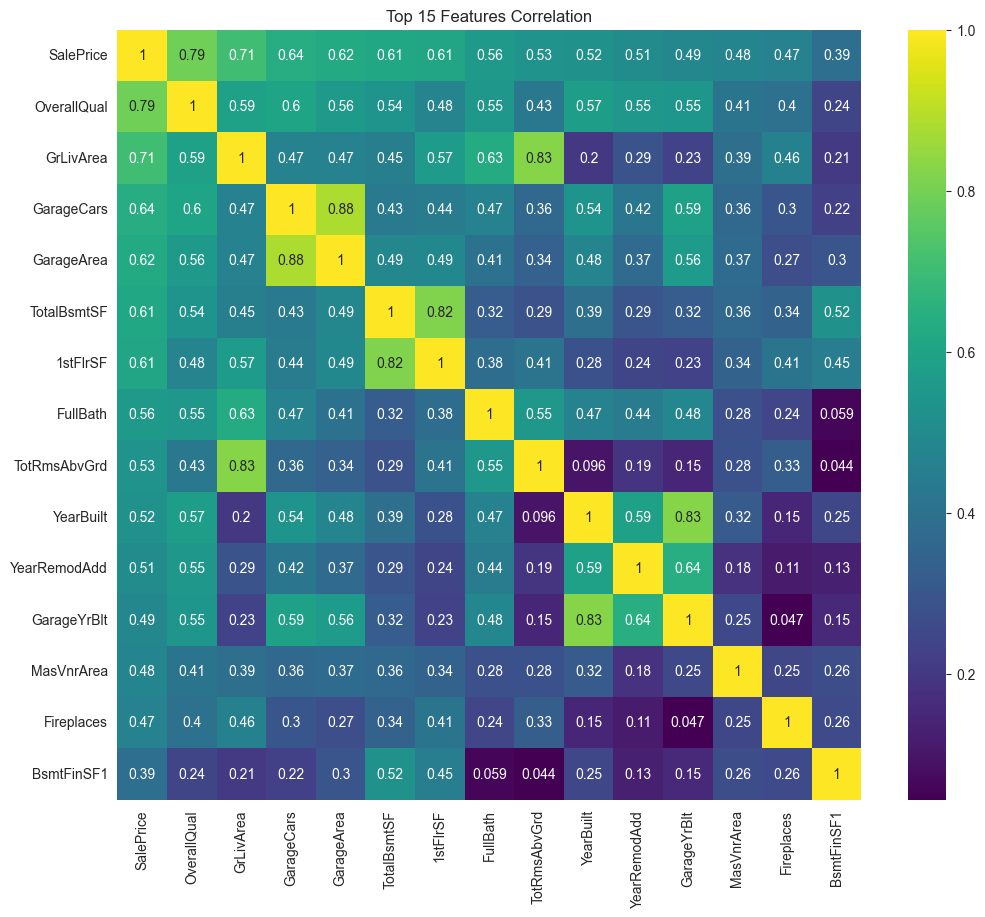

In [16]:
corr_matrix = train_df.select_dtypes(include=['number']).corr()
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[top_corr_features].corr(), annot=True, cmap='viridis')
plt.title('Top 15 Features Correlation')
plt.show()


Text(0.5, 1.0, 'GrLivArea vs SalePrice')

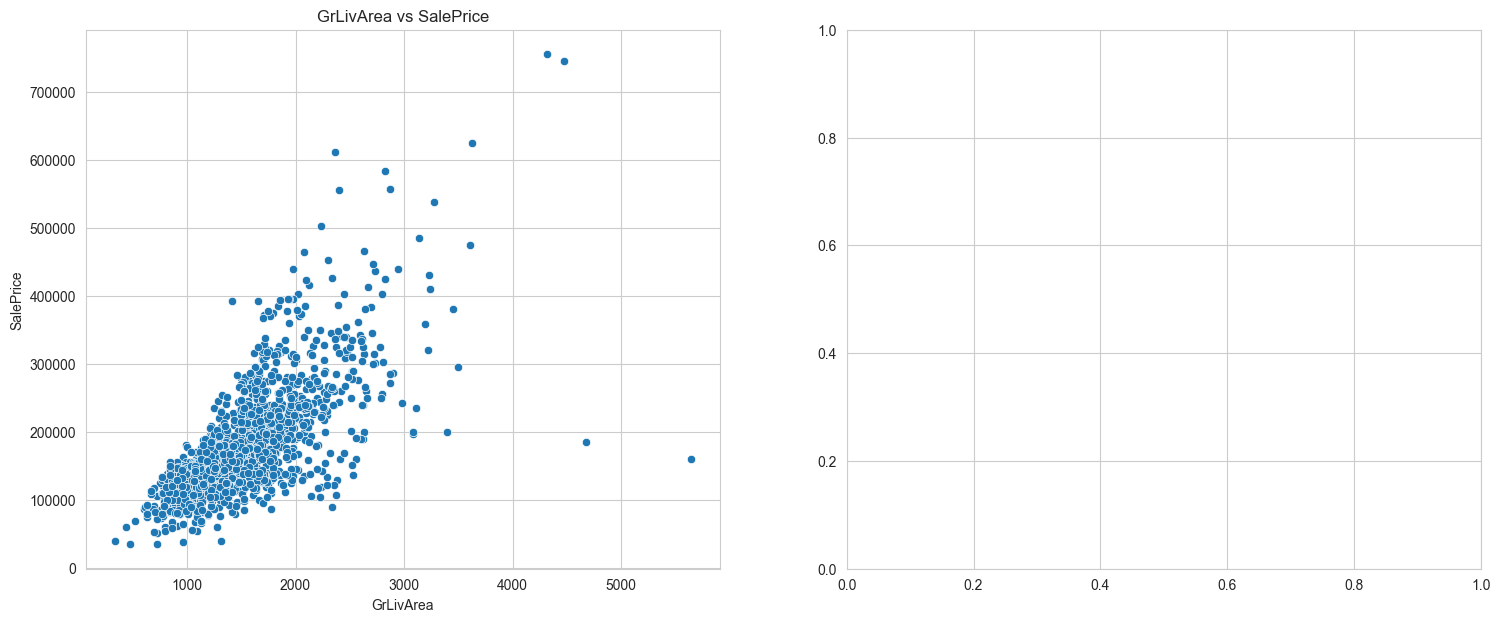

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'], ax=axes[0])
axes[0].set_title('GrLivArea vs SalePrice')

In [21]:
sns.boxplot(x=train_df['OverallQual'], y=train_df['SalePrice'],  ax=axes[1])
axes[1].set_title('SalePrice vs OverallQual')
plt.show()

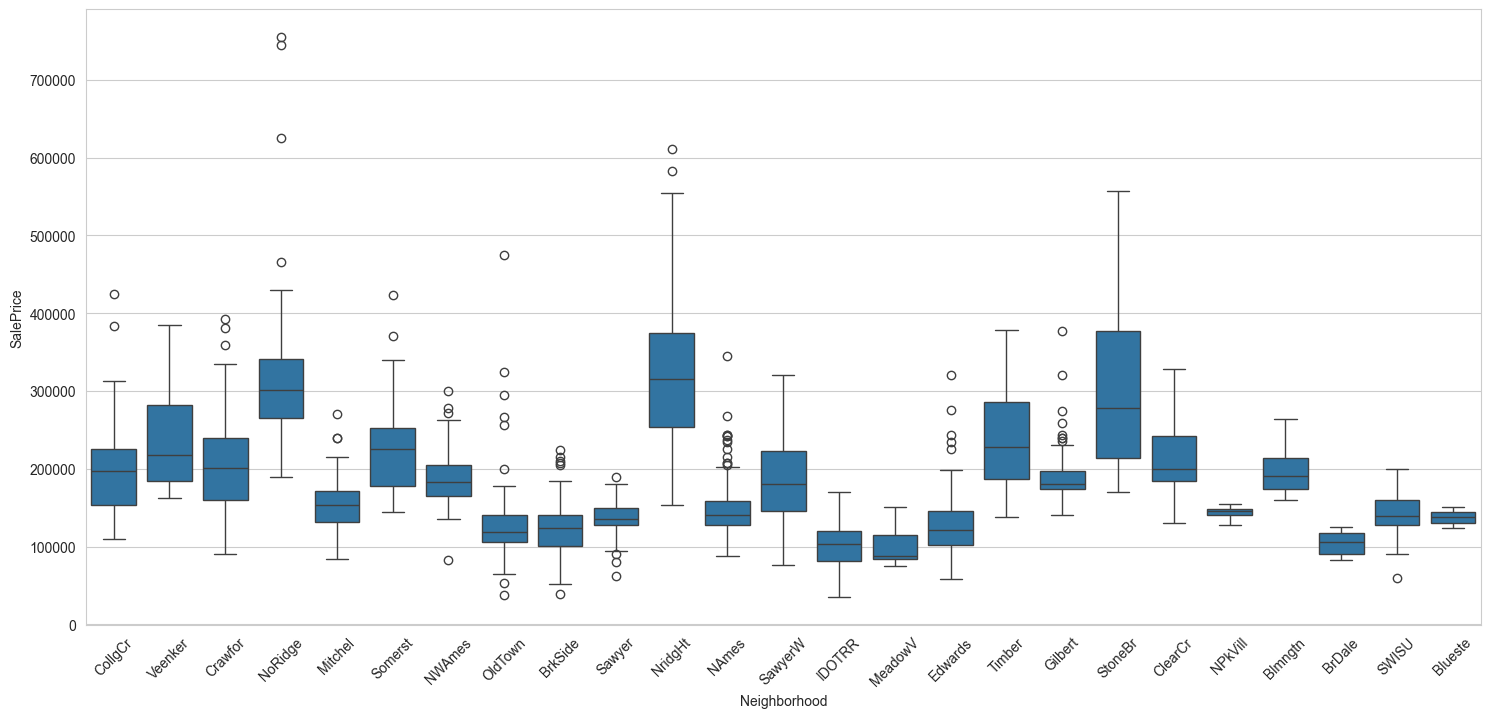

In [22]:
plt.figure(figsize=(18, 8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df)
plt.xticks(rotation=45)
plt.show()

In [24]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)

y_train_full = train_df['SalePrice']
all_data = pd.concat((train_df.drop('SalePrice', axis=1), test_df))

In [26]:
cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in cols_fill_none:
    all_data[col] = all_data[col].fillna('None')

cols_fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for col in cols_fill_zero:
    all_data[col] = all_data[col].fillna(0)

for col in all_data.select_dtypes(include='object'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [27]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

y_train_log = np.log1p(y_train_full)

In [28]:
numeric_feats = all_data.select_dtypes(exclude='object').columns
skewed_feats = all_data[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_feats = skewed_feats[skewed_feats > 0.75].index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [29]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['IsNew'] = (all_data['YearBuilt'] == all_data['YrSold']).astype(int)

all_data_encoded = pd.get_dummies(all_data)

In [30]:
X = all_data_encoded[:len(y_train_log)]
X_test_final = all_data_encoded[len(y_train_log):]
X, X_test_final = X.align(X_test_final, join='left', axis=1, fill_value=0)

X_train, X_val, y_train, y_val = train_test_split(X, y_train_log, test_size=0.2, random_state=42)

In [31]:
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)
evaluate_model(y_val, lr.predict(X_val), "Linear Regression")

Linear Regression - MAE: 0.0903, RMSE: 0.1412, R²: 0.8817


In [33]:
rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(y_val, rf.predict(X_val), "Random Forest")

Random Forest - MAE: 0.0955, RMSE: 0.1422, R²: 0.8800


In [34]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.1, max_depth=4, min_child_weight=3, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
evaluate_model(y_val, xgb_preds, "XGBoost")

XGBoost - MAE: 0.0878, RMSE: 0.1244, R²: 0.9082



--- Final Model Analysis (XGBoost) ---


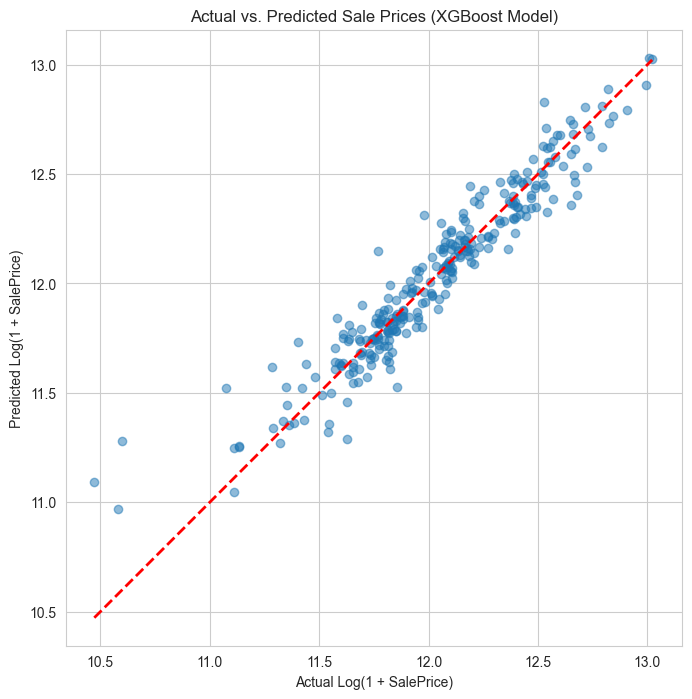

In [35]:
print("\n--- Final Model Analysis (XGBoost) ---")

# 6.1: Plot Predicted vs. Actual Values
plt.figure(figsize=(8, 8))
plt.scatter(y_val, xgb_preds, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Sale Prices (XGBoost Model)')
plt.xlabel('Actual Log(1 + SalePrice)')
plt.ylabel('Predicted Log(1 + SalePrice)')
plt.axis('equal')
plt.axis('square')
plt.show()

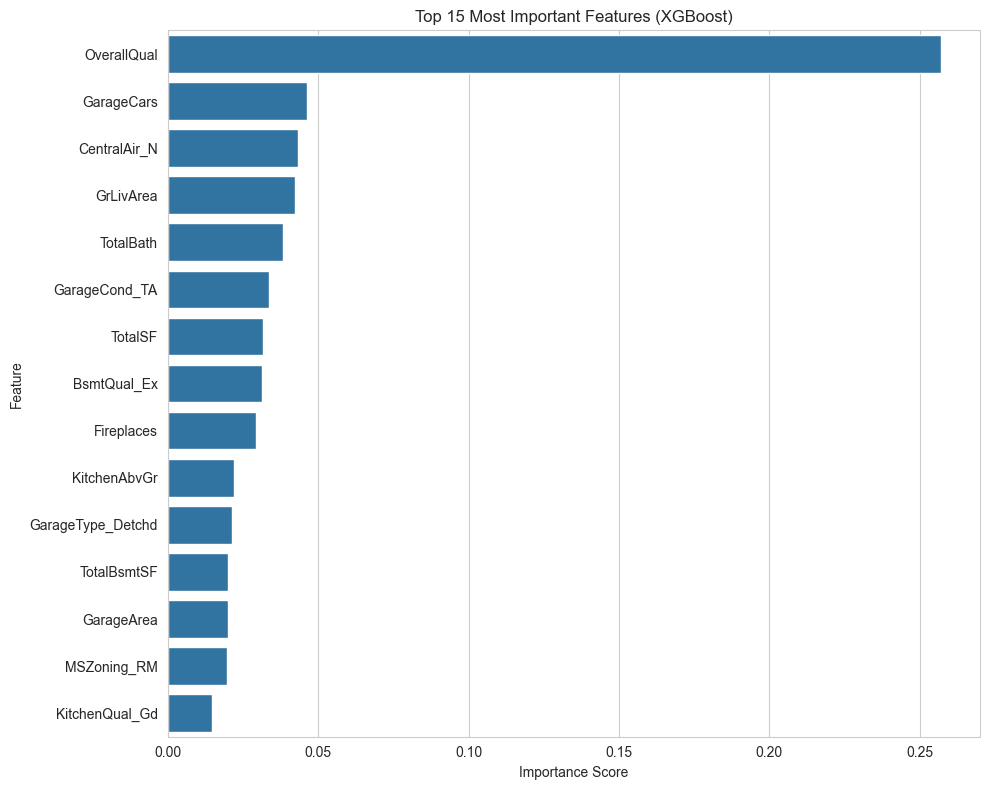


--- Project Execution Complete ---


In [37]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, )
plt.title('Top 15 Most Important Features (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n--- Project Execution Complete ---")
